<a href="https://colab.research.google.com/github/Orri050/Lokaverkefni/blob/main/Lokaverkefni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forritið

## Grunnur

In [201]:
pip install yfinance

In [202]:
pip install plotly

In [574]:
import tensorflow as tf
import math
from pandas.tseries.offsets import DateOffset
from datetime import timedelta, date
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import datetime as dt
import yfinance as yf
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit



## Val á hlutabréfi

In [433]:
choice = input('Write a stock symbol:')
choice = choice.upper()

Write a stock symbol:NFLX


## Hlutabréf gögn

In [578]:
data = yf.download(tickers=choice, start="2019-03-04", end="2022-04-18", interval='1d')
#data = yf.download(tickers=choice, period = 'max', interval = '1d', rounding= True)

[*********************100%***********************]  1 of 1 completed


In [435]:
data_Open=data[['Open']] #this returns a DataFrame, you don't need loc
data_dates=data.index.to_frame().reset_index(drop=True)
data_dates=data_dates.apply(pd.to_datetime)

### yf.ticker 

In [579]:
yf.pdr_override()
stock = yf.Ticker(choice)

In [580]:
stockh = stock.history(period='max',start="2019-03-04",end="2022-04-18", interval='1d')
#stockh = stock.history(period='max', interval='1d')
stockh

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-04,359.720001,362.250000,348.040009,351.040009,7487000,0,0
2019-03-05,351.459991,356.170013,348.250000,354.299988,5937800,0,0
2019-03-06,353.600006,359.880005,351.700012,359.609985,6211900,0,0
2019-03-07,360.160004,362.859985,350.500000,352.600006,6151300,0,0
2019-03-08,345.750000,349.920013,342.470001,349.600006,6898800,0,0
...,...,...,...,...,...,...,...
2022-04-08,361.959991,362.500000,354.869995,355.880005,4020500,0,0
2022-04-11,350.000000,354.779999,345.200012,348.000000,3777100,0,0
2022-04-12,355.910004,359.410004,342.250000,344.100006,3824300,0,0


In [438]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [439]:
stockh.index

DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13',
               '2019-03-14', '2019-03-15',
               ...
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-18'],
              dtype='datetime64[ns]', name='Date', length=789, freq=None)

In [ ]:
stockh_Open=stockh[['Open']] #this returns a DataFrame, you don't need loc
stockh_dates=stockh.index.to_frame().reset_index(drop=True)
stockh_dates=stockh_dates.apply(pd.to_datetime)

In [441]:
jon=stock.dividends
divi_dates=jon.index.to_frame().reset_index(drop=True)
divi_dates=divi_dates.apply(pd.to_datetime)
print(divi_dates)

Empty DataFrame
Columns: [Date]
Index: []


In [ ]:

start = dt.datetime.strptime("2019-03-04", "%Y-%m-%d")
end = dt.datetime.strptime("2022-05-30", "%Y-%m-%d")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]
date_generated

In [ ]:
add_dates = [data.index[-1] + DateOffset(days=x) for x in range(0,32) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=data.columns)
future_dates

In [573]:
hass=pd.date_range(start="2019-03-04",end="2022-05-30")
#hass=hass.apply(pd.to_datetime)
pd.to_datetime(hass)

DatetimeIndex(['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-09', '2019-03-10', '2019-03-11',
               '2019-03-12', '2019-03-13',
               ...
               '2022-05-21', '2022-05-22', '2022-05-23', '2022-05-24',
               '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28',
               '2022-05-29', '2022-05-30'],
              dtype='datetime64[ns]', length=1184, freq='D')

## Open close

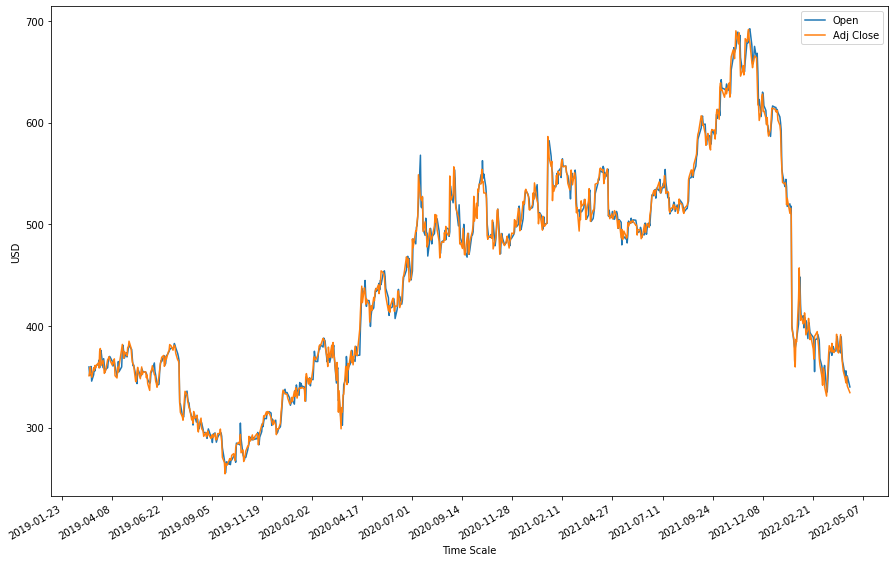

In [452]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['Open'], label='Open')
plt.plot(x_dates, data['Adj Close'], label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## High low

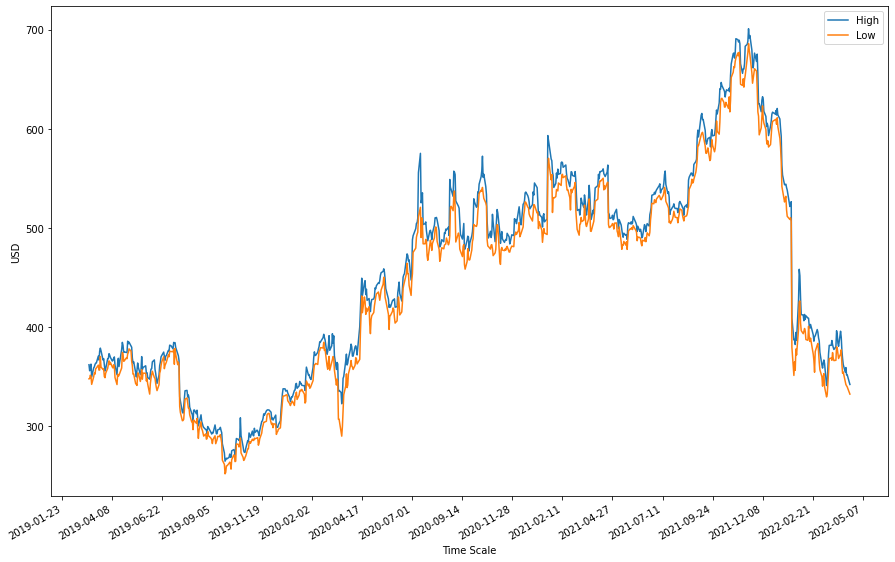

In [453]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['High'], label='High')
plt.plot(x_dates, data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Fyrsta módel

### Gagnaundirbúningur

In [454]:
target_y = data['Adj Close']
X_feat= data.iloc[:,0:5]
h_feat=data.iloc[:,4]

In [455]:
h_feat

Date
2019-03-04    351.040009
2019-03-05    354.299988
2019-03-06    359.609985
2019-03-07    352.600006
2019-03-08    349.600006
                 ...    
2022-04-11    348.000000
2022-04-12    344.100006
2022-04-13    350.429993
2022-04-14    341.130005
2022-04-18    334.410004
Name: Adj Close, Length: 789, dtype: float64

In [456]:
X_feat

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-03-04,359.720001,362.250000,348.040009,351.040009,351.040009
2019-03-05,351.459991,356.170013,348.250000,354.299988,354.299988
2019-03-06,353.600006,359.880005,351.700012,359.609985,359.609985
2019-03-07,360.160004,362.859985,350.500000,352.600006,352.600006
2019-03-08,345.750000,349.920013,342.470001,349.600006,349.600006
...,...,...,...,...,...
2022-04-11,350.000000,354.779999,345.200012,348.000000,348.000000
2022-04-12,355.910004,359.410004,342.250000,344.100006,344.100006
2022-04-13,343.920013,352.000000,341.160004,350.429993,350.429993


In [457]:
h_ft=np.array(h_feat)
h_ft=h_ft.reshape(-1,1)

In [458]:
sc= StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft,index=X_feat.index)


In [459]:
h_ft=sc.fit_transform(h_ft)

In [460]:
def lstm_split(data, n_steps):
  X, y=[], []
  for i in range(len(data)-n_steps+1):
    X.append(data[i:i+n_steps,:-1])
    y.append(data[i+n_steps-1,-1])

  return np.array(X), np.array(y)


In [461]:
X11, y11= lstm_split(X_ft.values, n_steps=1)

train_split=0.8
split_idx= int(np.ceil(len(X11)*train_split))
date_index=X_ft.index

Xtr1, Xtst1= X11[:split_idx], X11[split_idx:]
ytr1, ytst1= y11[:split_idx], y11[split_idx:]
Xtrd1, Xtstd1= date_index[:split_idx], date_index[split_idx:]

print(X11.shape, Xtr1.shape, Xtst1.shape, ytst1.shape)

(789, 1, 4) (632, 1, 4) (157, 1, 4) (157,)


### Modelið

In [462]:
model1 = keras.models.Sequential([
    keras.layers.LSTM(32,input_shape=(Xtr1.shape[1],Xtr1.shape[2]), activation="relu",return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)])
model1.compile(loss="mean_squared_error", optimizer="adam")
model1.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 1, 32)             4736      
                                                                 
 lstm_52 (LSTM)              (None, 32)                8320      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [463]:
history1=model1.fit(Xtr1,ytr1,epochs=100,validation_data=(Xtst1, ytst1),batch_size=4,verbose=2,shuffle=False)

Epoch 1/100
158/158 - 3s - loss: 0.4491 - val_loss: 0.0184 - 3s/epoch - 20ms/step
Epoch 2/100
158/158 - 0s - loss: 0.0079 - val_loss: 0.0084 - 449ms/epoch - 3ms/step
Epoch 3/100
158/158 - 0s - loss: 0.0030 - val_loss: 0.0103 - 440ms/epoch - 3ms/step
Epoch 4/100
158/158 - 0s - loss: 0.0029 - val_loss: 0.0111 - 454ms/epoch - 3ms/step
Epoch 5/100
158/158 - 0s - loss: 0.0028 - val_loss: 0.0112 - 453ms/epoch - 3ms/step
Epoch 6/100
158/158 - 0s - loss: 0.0027 - val_loss: 0.0111 - 443ms/epoch - 3ms/step
Epoch 7/100
158/158 - 0s - loss: 0.0025 - val_loss: 0.0112 - 453ms/epoch - 3ms/step
Epoch 8/100
158/158 - 0s - loss: 0.0024 - val_loss: 0.0114 - 438ms/epoch - 3ms/step
Epoch 9/100
158/158 - 0s - loss: 0.0023 - val_loss: 0.0116 - 442ms/epoch - 3ms/step
Epoch 10/100
158/158 - 0s - loss: 0.0022 - val_loss: 0.0117 - 445ms/epoch - 3ms/step
Epoch 11/100
158/158 - 0s - loss: 0.0021 - val_loss: 0.0116 - 448ms/epoch - 3ms/step
Epoch 12/100
158/158 - 0s - loss: 0.0020 - val_loss: 0.0114 - 440ms/epoch - 

In [464]:
ypr=model1.predict(Xtst1)
#ypr=ypr.reshape(-1)

### Lærdómskúrva

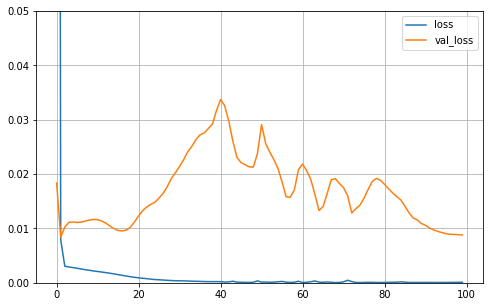

In [465]:
pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.05)
plt.show()

### Samanburður á raunverulegu close og mati LSTM

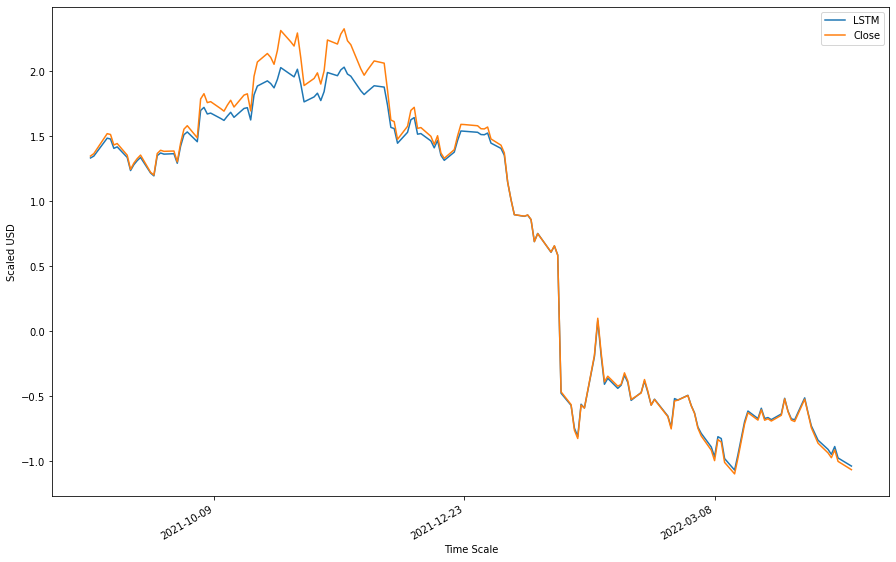

In [466]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr1)
x_dates=data_dates[k:]
#h=stockh['Close']
h=h_ft[k:]
#h=h[k:]
plt.plot(x_dates, ypr, label='LSTM')
plt.plot(x_dates, h, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [467]:
rmse=mean_squared_error(ytst1,ypr,squared=False)
mape=mean_absolute_percentage_error(ytst1,ypr)
print("RSME:",rmse)
print("MAPE:",mape)

RSME: 0.09382222151346094
MAPE: 0.03673901614957866


In [468]:
Villa1 = (rmse+mape)/2

## Annað módel

### Þjálfun

In [469]:
model2 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(Xtr1.shape[1],Xtr1.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
model2.compile(loss="mean_squared_error", optimizer="adam")
model2.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 1, 50)             11000     
                                                                 
 lstm_54 (LSTM)              (None, 1, 50)             20200     
                                                                 
 lstm_55 (LSTM)              (None, 50)                20200     
                                                                 
 dense_30 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51,451
Trainable params: 51,451
Non-trainable params: 0
_________________________________________________________________


In [470]:
#history2=model2.fit(Xtr,ytr,epochs=100,batch_size=4,verbose=2,shuffle=False)

In [471]:
history2 = model2.fit(Xtr1, ytr1, epochs=100, batch_size=50, validation_data=(Xtst1, ytst1), verbose=2, shuffle=False)

Epoch 1/100
13/13 - 7s - loss: 0.7774 - val_loss: 1.8556 - 7s/epoch - 561ms/step
Epoch 2/100
13/13 - 0s - loss: 0.7271 - val_loss: 1.7446 - 102ms/epoch - 8ms/step
Epoch 3/100
13/13 - 0s - loss: 0.6365 - val_loss: 1.4996 - 84ms/epoch - 6ms/step
Epoch 4/100
13/13 - 0s - loss: 0.4463 - val_loss: 1.0978 - 100ms/epoch - 8ms/step
Epoch 5/100
13/13 - 0s - loss: 0.1585 - val_loss: 0.6968 - 89ms/epoch - 7ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0478 - val_loss: 0.4877 - 110ms/epoch - 8ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0182 - val_loss: 0.3312 - 90ms/epoch - 7ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0075 - val_loss: 0.2266 - 92ms/epoch - 7ms/step
Epoch 9/100
13/13 - 0s - loss: 0.0069 - val_loss: 0.1939 - 106ms/epoch - 8ms/step
Epoch 10/100
13/13 - 0s - loss: 0.0070 - val_loss: 0.2012 - 87ms/epoch - 7ms/step
Epoch 11/100
13/13 - 0s - loss: 0.0068 - val_loss: 0.2112 - 106ms/epoch - 8ms/step
Epoch 12/100
13/13 - 0s - loss: 0.0065 - val_loss: 0.2137 - 103ms/epoch - 8ms/step
Epoch 13/100
13/13 

In [472]:
ypr2=model2.predict(Xtst1)
#ypr2=ypr2.reshape(-1)

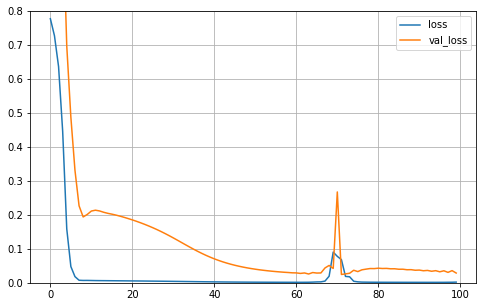

In [473]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.8)
plt.show()

### Samanburður á raunverulegu og LSTM

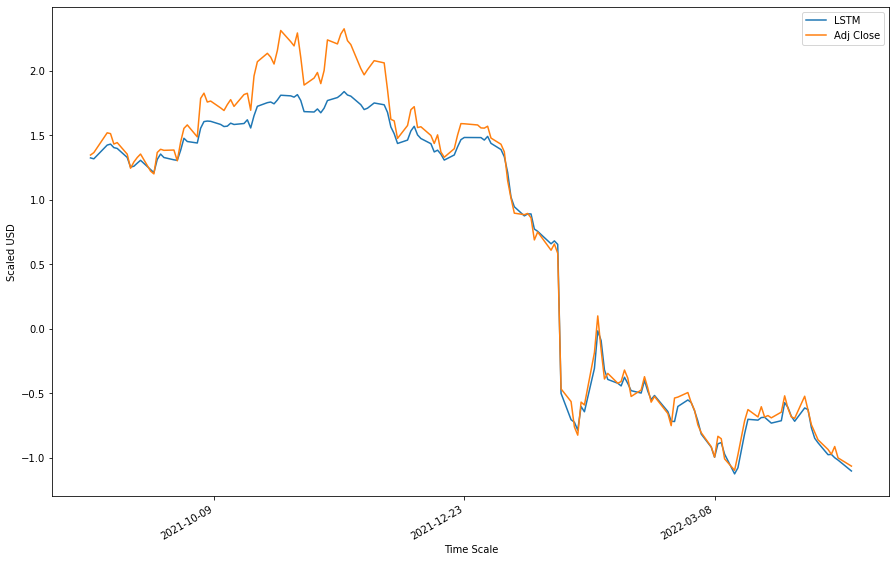

In [474]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr1)
x_dates=data_dates[k:]
#h=data['Adj Close']
h=h_ft[k:]
#h=h[k:]
plt.plot(x_dates, ypr2, label='LSTM')
plt.plot(x_dates, h, label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [475]:
rmse2=mean_squared_error(ytst1,ypr2,squared=False)
mape2=mean_absolute_percentage_error(ytst1,ypr2)
print("RSME:",rmse2)
print("MAPE:",mape2)

RSME: 0.16950781399960468
MAPE: 0.09246178156816359


In [476]:
Villa2=(rmse2+mape2)/2

## Þriðja módel

### Þjálfun

In [477]:
n_steps=10
X12, y12= lstm_split(X_ft.values, n_steps=n_steps)

train_split=0.8
split_idx= int(np.ceil(len(X12)*train_split))
date_index=X_ft.index

Xtr2, Xtst2= X12[:split_idx], X12[split_idx:]
ytr2, ytst2= y12[:split_idx], y12[split_idx:]
Xtrd2, Xtstd2= date_index[:split_idx], date_index[split_idx:-n_steps+1]

print(X12.shape, Xtr2.shape, Xtst2.shape,Xtstd2.shape, ytst2.shape)

(780, 10, 4) (624, 10, 4) (156, 10, 4) (156,) (156,)


In [478]:
#model = Sequential()
#model.add(LSTM(50, return_sequences=True))
#model.add(Dropout(0.1))
#model.add(LSTM(50))
#model.add(Dropout(0.1))
#model.add(Dense(1, activation='linear'))
#model.compile(loss='mean_squared_error', optimizer='adam')

In [479]:
#model3 = keras.models.Sequential([
    #keras.layers.LSTM(50,input_shape=(Xtr.shape[1],Xtr.shape[2]), activation="relu",return_sequences=True),
    #keras.layers.LSTM(50,activation="relu"),
    #keras.layers.Dense(1)])
#model3.compile(loss="mean_squared_error", optimizer="adam")
#model3.summary()

In [480]:
model3 = keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)])
model3.compile(loss="mean_squared_error", optimizer="adam")

In [ ]:
history3 = model3.fit(Xtr2, ytr2, epochs=100, batch_size=50, validation_data=(Xtst2, ytst2), verbose=2, shuffle=False)

In [482]:
ypr3=model3.predict(Xtst2)
#ypr3=ypr3.reshape(-1)

### Lærdómskúrva

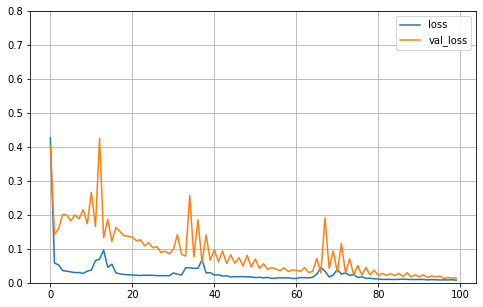

In [483]:
pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.8)
plt.show()

### Samanburður

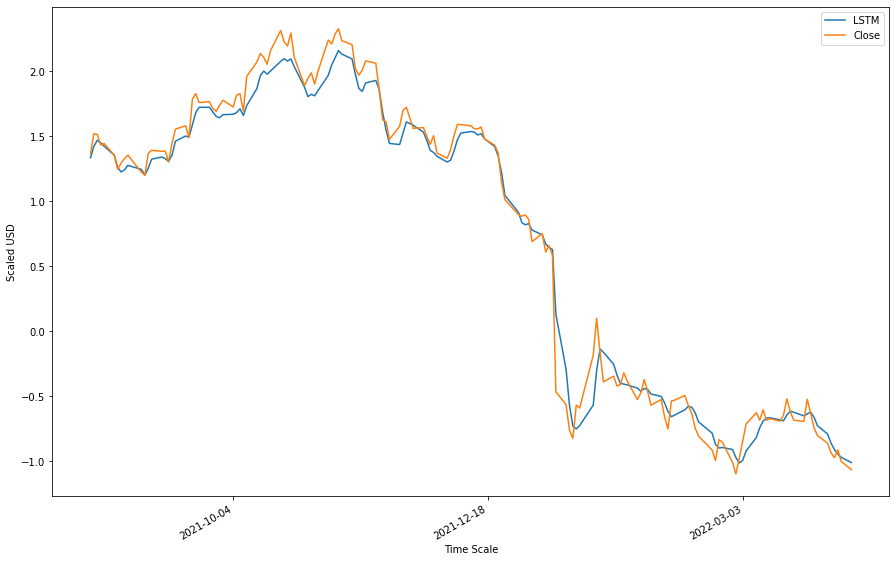

In [484]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr2)
thri=len(X12)-len(Xtstd2)
x_dates=data_dates[k:]
#h=stockh['Close']
n=n_steps-1
h=h_ft[thri+n:]
#h=h[k:]
plt.plot(Xtstd2, ypr3, label='LSTM')
plt.plot(Xtstd2, h, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE

In [485]:
rmse3=mean_squared_error(ytst2,ypr3,squared=False)
mape3=mean_absolute_percentage_error(ytst2,ypr3)
print("RSME:",rmse3)
print("MAPE:",mape3)

RSME: 0.12115797769241629
MAPE: 0.12818833505680902


In [486]:
Villa3=(rmse3+mape3)/2

## MAPE

Test RMSE: 17.095
Test MAPE: 0.084


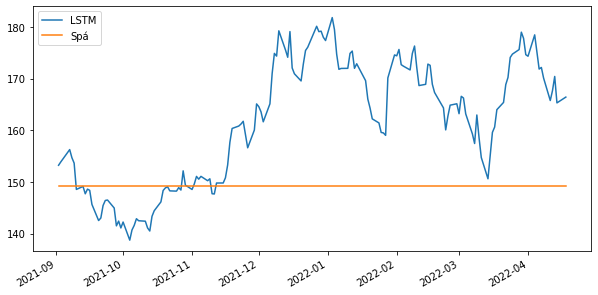

In [261]:
train_split=0.8
split_idx2= int(np.ceil(len(data)*train_split))
tr=data[['Adj Close']].iloc[:split_idx2]
tst=data[['Adj Close']].iloc[split_idx2:]

tstpr=np.array([tr.rolling(10).mean().iloc[-1]]*len(tst)).reshape((-1,1))

print('Test RMSE: %.3f'%mean_squared_error(tst,tstpr,squared=False))
print('Test MAPE: %.3f'%mean_absolute_percentage_error(tst,tstpr))
f=len(tst)-len(h)
z=n-f
x_dates=data_dates[k+z:]


plt.figure(figsize=(10,5))
#plt.plot(tst)
#plt.plot(tstpr)
plt.plot(x_dates, tst, label='LSTM')
plt.plot(x_dates, tstpr, label='Spá')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

Test RMSE: 16.585
Test MAPE: 0.082


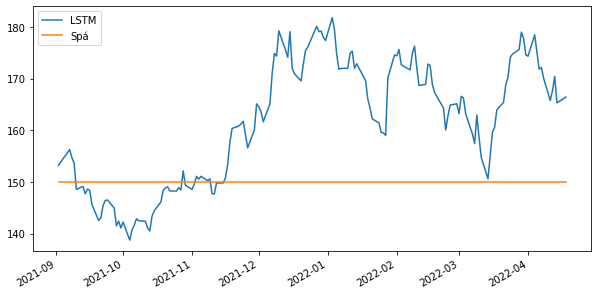

In [260]:
from statsmodels.tsa.api import SimpleExpSmoothing

J=data[['Adj Close']].values
train_split=0.8
split_idx3= int(np.ceil(len(J)*train_split))
tr2=J[:split_idx3]
tst2=J[split_idx3:]
tst_concat=np.array([]).reshape((0,1))

for i in range(len(tst2)):
  tr_fit=np.concatenate((tr2,np.asarray(tst_concat)))
  fit=SimpleExpSmoothing(np.asarray(tr_fit)).fit(smoothing_level=0.2)
  tst_pr=fit.forecast(1)
  tst_concat=np.concatenate((np.asarray(tst_concat),tst_pr.reshape((-1,1))))

print('Test RMSE: %.3f'%mean_squared_error(tst2,tst_concat,squared=False))
print('Test MAPE: %.3f'%mean_absolute_percentage_error(tst2,tst_concat))
f=len(tst2)-len(h)
z=n-f
x_dates=data_dates[k+z:]

plt.figure(figsize=(10,5))
#plt.plot(tst)
#plt.plot(tstpr)
plt.plot(x_dates, tst2, label='LSTM')
plt.plot(x_dates, tst_concat, label='Spá')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


## Val á modeli með minnstu villuna

In [487]:
smallest = 0
if Villa1 < Villa2 and Villa1 < Villa3 :
    smallest = 'Model1'
if Villa2 < Villa1 and Villa2 < Villa3 :
    smallest = 'Model2'
if Villa3 < Villa1 and Villa3 < Villa2 :
    smallest = 'Model3'
print(smallest, "er með minnstu villuna.")
print("Við veljum þá", smallest)

Model1 er með minnstu villuna.
Við veljum þá Model1


## fram í tímann

### val á gögnum

In [488]:
df1=data.reset_index()['Adj Close']
#df1

### Mynd af gögnum sem voru valin

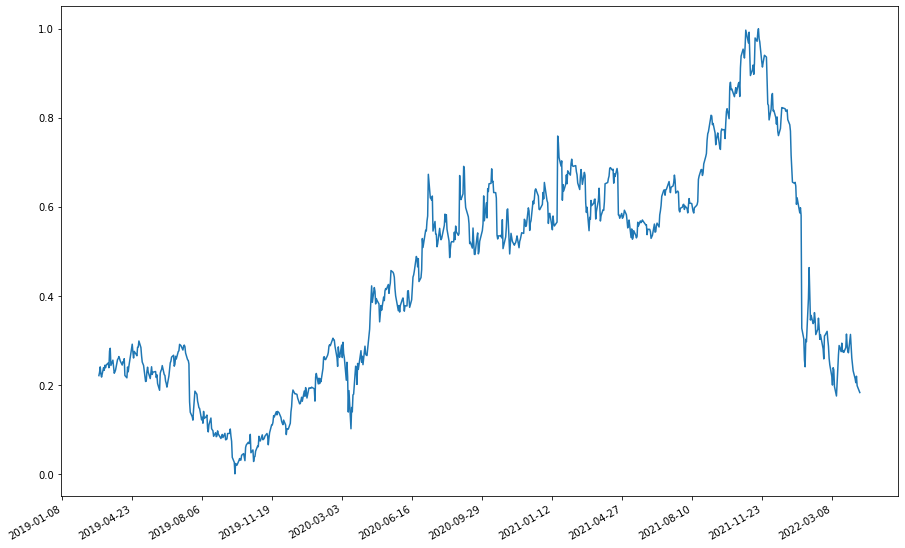

In [527]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=105))
x_dates=data_dates
#plt.plot(df1)
plt.plot(x_dates, df1, label='Close')
plt.gcf().autofmt_xdate()

### Gagnavinnsla

In [494]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [266]:
#print(df1)

In [495]:
trainstaerd=int(len(df1)*0.65)
tststaerd=len(df1)-trainstaerd
train_data,test_data=df1[0:trainstaerd,:],df1[trainstaerd:len(df1),:1]

In [496]:
trainstaerd,tststaerd

(512, 277)

In [269]:
#train_data

In [497]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [498]:
time_step = 100
Xtr3, ytr3 = create_dataset(train_data, time_step)
Xtst3, ytst3 = create_dataset(test_data, time_step)

In [499]:
print(Xtr3.shape)
print(ytr3.shape)

(411, 100)
(411,)


In [501]:
print(Xtst3.shape), print(ytst3.shape)

(176, 100)
(176,)


(None, None)

In [502]:
Xtr3 =Xtr3.reshape(Xtr3.shape[0],Xtr3.shape[1] , 1)
Xtst3 = Xtst3.reshape(Xtst3.shape[0],Xtst3.shape[1] , 1)

In [ ]:
#model1 = keras.models.Sequential([
    #keras.layers.LSTM(32,input_shape=(Xtr3.shape[1],Xtr3.shape[2]), activation="relu",return_sequences=True),
    #keras.layers.LSTM(32),
    #keras.layers.Dense(1)])
#model1.compile(loss="mean_squared_error", optimizer="adam")
#model1.summary()

### Modelið

In [ ]:

if smallest=='Model1' :
    print("Við notum Model1")
    model1 = keras.models.Sequential([
    keras.layers.LSTM(32,input_shape=(Xtr3.shape[1],Xtr3.shape[2]), activation="relu",return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)])
    model1.compile(loss="mean_squared_error", optimizer="adam")
    model1.summary()
    model1.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=4,verbose=2)   
if smallest=='Model2' :
    print("Við notum Model2")
    model2 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(Xtr3.shape[1],Xtr3.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
    model2.compile(loss="mean_squared_error", optimizer="adam")
    model2.summary()
    model2.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=50,verbose=2) 
if smallest=='Model3' :
    print("Við notum Model3")
    model3 = keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)])
    model3.compile(loss="mean_squared_error", optimizer="adam")
    model3.summary()
    model3.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=50,verbose=2) 

In [165]:
#model6 = keras.models.Sequential([
    #keras.layers.LSTM(50,input_shape=(Xtr3.shape[1],Xtr3.shape[2]),return_sequences=True),
    #keras.layers.LSTM(50,return_sequences=True),
    #keras.layers.LSTM(50),
    #keras.layers.Dense(1)])
#model6.compile(loss="mean_squared_error", optimizer="adam")
#model6.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_19 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model6.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=64,verbose=2)

### Spágögn búin til

In [529]:
mod=0
if smallest=='Model1' :
  train_predict=model1.predict(Xtr3)
  test_predict=model1.predict(Xtst3)
  mod=model1
if smallest=='Model2' :
  train_predict=model2.predict(Xtr3)
  test_predict=model2.predict(Xtst3)
  mod=model2
if smallest=='Model3' :
  train_predict=model3.predict(Xtr3)
  test_predict=model3.predict(Xtst3)
  mod=model3

In [176]:
#train_predict=model6.predict(Xtr3)
#test_predict=model6.predict(Xtst3)

In [303]:
  #train_predict=train_predict.reshape(-2)
  #test_predict=test_predict.reshape(-2)

In [337]:
#train_predict=train_predict.reshape(-1,1)
#test_predict=test_predict.reshape(-1,1)

In [ ]:
#train_predict = train_predict.reshape((train_predict[0],train_predict[1]*train_predict[2]))

In [505]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### RMSE 

In [506]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(ytr3,train_predict))

426.45948369558187

In [507]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytst3,test_predict))

531.6251315252292

### Mynd af einhverju (skoða)

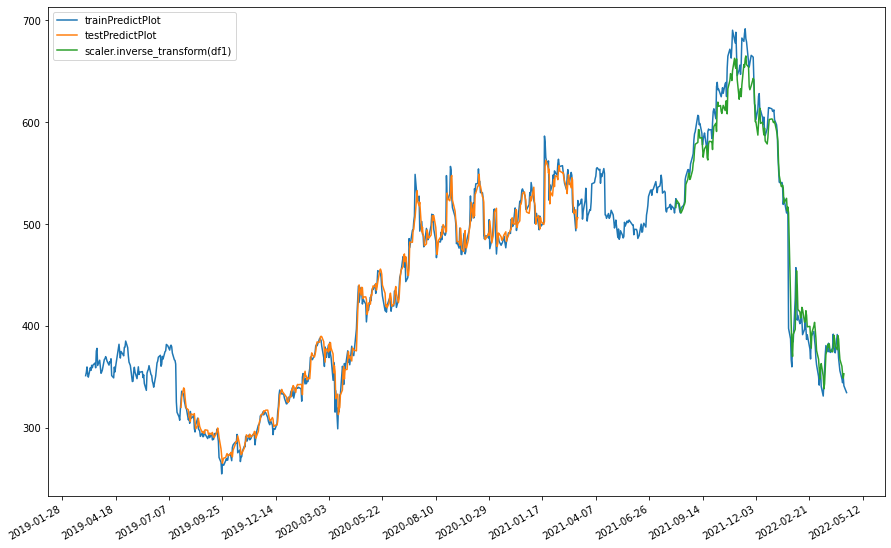

In [528]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=80))
x_dates=data_dates
plt.plot(data_dates,scaler.inverse_transform(df1))
plt.plot(data_dates,trainPredictPlot)
plt.plot(data_dates,testPredictPlot)
plt.legend(['trainPredictPlot', 'testPredictPlot','scaler.inverse_transform(df1)'],loc='upper left')
plt.gcf().autofmt_xdate()
plt.show()

### Framtíðargögn sett í fylki

In [510]:
len(test_data)

277

In [511]:
timi=len(test_data)-100


In [512]:
x_input=test_data[timi:].reshape(1,-1)
x_input.shape

(1, 100)

In [513]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [514]:
#temp_input

In [ ]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = mod.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = mod.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [531]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [532]:
len(df1)

789

In [533]:
tim=len(df1)-100

### Mynd af spá ósamsett

In [611]:
#df1.shape

(789, 1)

In [602]:
fdata = pd.concat([data, future_dates], axis=0)
framtid=fdata.index.to_frame().reset_index(drop=True)
framtid=framtid.apply(pd.to_datetime)
#len(framtid)

819

In [609]:
spat=len(framtid)-30
sidf=len(framtid)-130

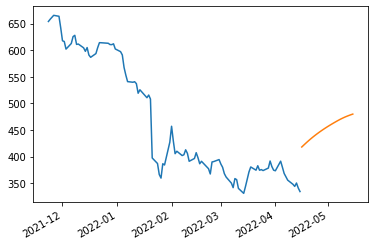

In [614]:
plt.plot(framtid[sidf:spat],scaler.inverse_transform(df1[tim:]))
plt.plot(framtid[spat:],scaler.inverse_transform(lst_output))
plt.gcf().autofmt_xdate()

In [535]:
timm=tim+30

### Mynd af spá samsett

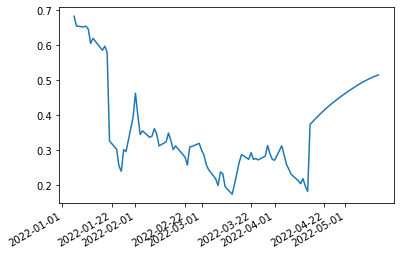

In [615]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(framtid[timm:],df3[timm:])
plt.gcf().autofmt_xdate()

In [537]:
df3=scaler.inverse_transform(df3).tolist()

### Mynd af heildargögnum með spá

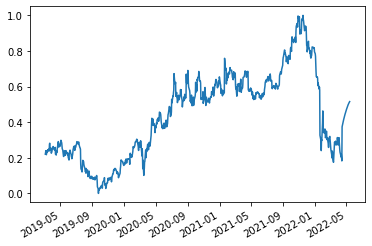

In [616]:
plt.plot(framtid,df3)
plt.gcf().autofmt_xdate()

## Nett grafdót

In [ ]:
choice = input('Write a stock symbol:')
choice = choice.upper()
data = yf.download(tickers=choice, period = 'max', interval = '1d', rounding= True)
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
fig = go.Figure()
fig.add_trace(go.Candlestick(x=data.index,open = data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name = 'market data'))
fig.add_trace(go.Scatter(x=data.index,y=data['MA5'],opacity=0.7,line=dict(color='blue', width=2),name='MA 5'))

fig.add_trace(go.Scatter(x=data.index,y=data['MA20'],opacity=0.7,line=dict(color='orange', width=2),name='MA 20'))
fig.update_layout(title = choice + ' share price', yaxis_title = 'Stock Price (USD)')
fig.update_xaxes(
rangeslider_visible=True,
rangeselector=dict(
buttons=list([
#dict(count=15, label='15m', step='minute', stepmode='backward'),
#dict(count=45, label='45m', step='minute', stepmode='backward'),
#dict(count=1, label='1h', step='hour', stepmode='backward'),
#dict(count=6, label='6h', step='hour', stepmode='backward'),
dict(count=30, label='30d', step='day', stepmode='backward'),
dict(count=3, label='3m', step='month', stepmode='backward'),
dict(count=6, label='6m', step='month', stepmode='backward'),
dict(count=1, label='YTD', step='year', stepmode='todate'),
dict(count=1, label='1y', step='year', stepmode='backward'),
dict(count=3, label='3y', step='year', stepmode='backward'),
dict(step='all')
])
)
)
fig.show()